Sheet 4.1: Non-linear regression (custom MLP)
=============================================

**Author:** Michael Franke



In this tutorial, we will fit a non-linear regression, implemented as a multi-layer perceptron.
First, we will implement it the hard way: coding the different layers in terms of explicitly spelled out matrix operations.
In the next worksheet, we will see how the use of modules from PyTorch&rsquo; neural network package \`torch.nn\` helps us implement the model in a more efficient way.
Going through the model entirely by hand, helps understand what is happening &rsquo;under the hood&rsquo; and also helps appreciating the high-level functionality provided by software like PyTorch.



Student: Jia Sheng (5371477)

## Packages & global parameters



We will need to import the \`torch\` package for the main functionality.
We specifically import the neural network functionalities from PyTorch as \`nn\`.
We use this here only for the training loss function (MSE).
In order to have a convenient handle, we load the \`torch.nn.functional\` package into variable \`F\`.
We use this to pick up the activation function (ReLU) we will use for our neural network.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# import sys
import warnings
warnings.filterwarnings('ignore')

We will also globally set the float precision to 64:



In [2]:
torch.set_default_dtype(torch.float64)

## True model



The &ldquo;true model&rdquo; is a constructed non-linear function $y = f(x)$.
Here is its definition and a plot to show what the &ldquo;ground truth&rdquo; looks like.



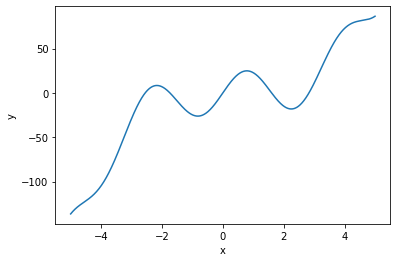

In [3]:
##################################################
## ground-truth model
##################################################

def goalFun(x):
    return(x**3 - x**2 + 25 * np.sin(2*x))

# create linear sequence (x) and apply goalFun (y)
x = np.linspace(start = -5, stop =5, num = 1000)
y = goalFun(x)

# plot the function
d = pd.DataFrame({'x' : x, 'y' : y})
sns.lineplot(data = d, x = 'x', y = 'y')
plt.show()

## Training data



The training data consists of 100 pairs of  $(x,y)$ values.
Each pair is generated by first sampling an $x$ value from a uniform distribution.
For each sampled $x$, we compute the value of the target function $f(x)$ and add Gaussian noise to it.



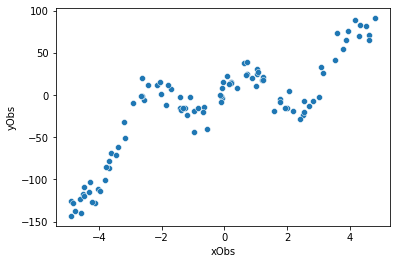

In [26]:
##################################################
## generate training data (with noise)
##################################################

nObs = 100 # number of observations

# get noise around y observations
yNormal = torch.distributions.Normal(loc=0.0, scale=10)
yNoise  = yNormal.sample([nObs])

# get observations
xObs = 10*torch.rand([nObs])-5    # uniform from [-5,5]
yObs = xObs**3 - xObs**2 + 25 * torch.sin(2*xObs) + yNoise

# plot the data
d = pd.DataFrame({'xObs' : xObs, 'yObs' : yObs})
sns.scatterplot(data = d, x = 'xObs', y = 'yObs')
plt.show()

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 4.1.1: Explore the training data</span></strong>
>
> 1. Remove the noise in the data by changing a single number (parameter value).
> 2. At what point is the noise in the data so large that there is nothing more to learn?



### Answer to Exercise 4.1.1.1

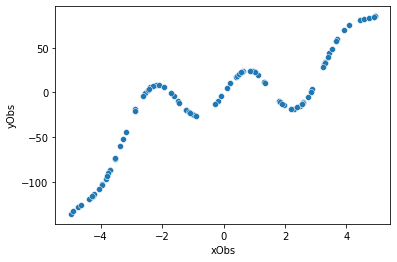

In [5]:
# remove the noise in the data by reducing the scale (standard deviation) to minimally small
yNormal = torch.distributions.Normal(loc=0.0, scale=0.0000000001)
yNoise  = yNormal.sample([nObs])

# get observations
xObs = 10*torch.rand([nObs])-5    # uniform from [-5,5]
yObs = xObs**3 - xObs**2 + 25 * torch.sin(2*xObs) + yNoise

# plot the data
d = pd.DataFrame({'xObs' : xObs, 'yObs' : yObs})
sns.scatterplot(data = d, x = 'xObs', y = 'yObs')
plt.show()

### Answer to Exercise 4.1.1.2

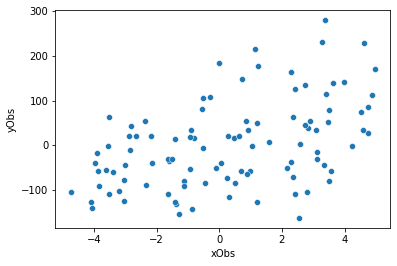

In [6]:
# raise the scale of noise distribution to a very large number
yNormal = torch.distributions.Normal(loc=0.0, scale=90)
yNoise  = yNormal.sample([nObs])

# get observations
xObs = 10*torch.rand([nObs])-5    # uniform from [-5,5]
yObs = xObs**3 - xObs**2 + 25 * torch.sin(2*xObs) + yNoise

# plot the data
d = pd.DataFrame({'xObs' : xObs, 'yObs' : yObs})
sns.scatterplot(data = d, x = 'xObs', y = 'yObs')
plt.show()

As can be observed above, when rasing the standard deviation of the noise to about 90 or 100, the noise is so large that there is almost no pattern in the data to learn.

## Hand-coding a multi-layer perceptron



Our model maps a single real number $x$ onto another single real number $y$.
We therefore have a neural network whith input and output dimension set to 1.
In between $x$ and $y$, we will use three hidden layers $h_{1}, h_{2}, h_{3}$ each with dimension 10:



In [8]:
##################################################
## network dimension parameters
##################################################

nInput  = 1
nHidden = 10
nOutput = 1

The networks parameters are four matrices and three slopes.
The first embedding is called $U$, the following two hidden-to-hidden transformations are $V_{1}$ and $V_{2}$, the hidden-to-output mapping is given by matrix $W$.



In [23]:
##################################################
## trainable (matrix & slope) parameters
##           --initializing weights --
##################################################

U  = torch.tensor(np.random.rand(nHidden,nInput) * 2 - 1,
                  requires_grad=True)
V1 = torch.tensor(np.random.rand(nHidden, nHidden) * 2 - 1,
                  requires_grad=True)
V2 = torch.tensor(np.random.rand(nHidden, nHidden) * 2 - 1,
                  requires_grad=True)
W  = torch.tensor(np.random.rand(nOutput, nHidden) * 2 - 1,
                  requires_grad=True)
b1 = torch.zeros((nHidden,1), requires_grad=True)
b2 = torch.zeros((nHidden,1), requires_grad=True)
b3 = torch.zeros((nHidden,1), requires_grad=True)

Next, we will define the forward pass.



In [21]:
##################################################
## forward pass
##################################################

activationFun = F.relu # use ReLU fct from PyTorch

# this function takes a /single/ observation for x as input
#   and it outputs a /single/ observation for y
#   we will NOT use this one, but include for better understanding
def singleForwardPass(x):
    h1 = activationFun(U*x + b1)
    h2 = activationFun(torch.mm(V1,h1) + b2)
    h3 = activationFun(torch.mm(V2,h2) + b3)
    y  = torch.mm(W,h3)
    return(y[0,0])

# this function takes a /vector/ of observations for x as input
#   and it outputs a /vector/ of observations for y
#   we will use this function as it is massively more efficient in training
def singleForwardPassBatched(xObs):
    xObsBatched = xObs.reshape(100,1,1)       # 100 1x1 matrices
    h1 = activationFun(U @ xObsBatched + b1)  # 100 column vectors
    h2 = activationFun(V1 @ h1 + b2)
    h3 = activationFun(V2 @ h2 + b3)
    y  = W @ h3
    yReshaped = torch.reshape(y,(-1,))
    return(yReshaped)

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 4.1.2: Digest the model, the parameters and their initialization</span></strong>
>
> 1. Verify that the functions &rsquo;singleForwardPass&rsquo; and &rsquo;singleForwardPassBatched&rsquo; do the same thing by comparing their predictions for the whole sequence of &rsquo;xObs&rsquo;.
> I.e., simply call &rsquo;singleForwardPassBatched&rsquo; and compare the output to calls of &rsquo;singleForwardPass&rsquo;.
> Ideally, produce outputs from &rsquo;singleForwardPass&rsquo; for all elements of &rsquo;xObs&rsquo; by list-comprehension.
>
> 2. Write down this model (forward pass) in mathematical notation. (The mathematical formulation of the model should follow the &rsquo;singleForwardPass&rsquo;).
>
> 3. Describe the way parameters are initialized (above) in your own intuitive terms?
>
> 4. Why can we not just set all parameter values to 0 initially?

It remains to instantiate an optimizer and to run execute the training loop.

Next, we will define the &rsquo;forward pass&rsquo;, i.e., a function that computes the predicted $y$ for a given input $x$ based on the current model parameters.



### Answer to Exercise 4.1.2.1

In [ ]:
# call ’singleForwardPassBatched’
print(singleForwardPassBatched(xObs))

tensor([-0.7850, -0.8012, -0.2039, -0.4159, -0.8262, -1.2719, -0.5368, -0.0881,
        -0.8213, -0.4302, -0.6580, -0.0766, -0.5973, -0.7097, -0.3272, -0.1946,
        -0.5709, -0.4204, -0.6278, -0.1524, -0.4173, -0.9126, -0.0722, -0.7075,
        -0.0322, -0.9266, -0.4215, -0.6293, -0.1171, -0.1796, -0.3400, -0.8160,
        -0.4490, -0.3560, -0.0030, -1.1371, -0.2007, -0.7098, -0.4041, -0.3464,
        -0.6072, -0.3543, -0.8315, -0.4333, -0.5069, -0.4551, -0.9607, -0.6752,
        -0.7630, -0.8320, -0.4507, -0.2224, -0.2181, -0.6099, -0.8868, -0.4841,
        -0.5942, -0.6345, -0.7950, -0.0968, -0.0116, -0.1548, -0.2138, -1.2269,
        -0.4113, -0.2013, -0.4286, -0.6244, -0.1861, -0.5018, -0.2748, -0.0050,
        -0.2366, -1.3943, -0.4865, -0.4983, -0.7294, -0.6067, -1.0379, -1.3256,
        -0.1717, -0.5125, -0.1590, -0.5264, -0.3349, -0.1523, -0.3558, -0.0951,
        -0.7346, -0.1548, -0.9469, -0.2740, -0.7483, -1.1042, -0.7454, -1.2911,
        -0.1619, -0.5951, -0.4449, -0.28

In [ ]:
# produce outputs from ’singleForwardPass’ for all elements of ’xObs’ by list-comprehension.
print([singleForwardPass(x).detach() for x in xObs])

[tensor(-0.7850), tensor(-0.8012), tensor(-0.2039), tensor(-0.4159), tensor(-0.8262), tensor(-1.2719), tensor(-0.5368), tensor(-0.0881), tensor(-0.8213), tensor(-0.4302), tensor(-0.6580), tensor(-0.0766), tensor(-0.5973), tensor(-0.7097), tensor(-0.3272), tensor(-0.1946), tensor(-0.5709), tensor(-0.4204), tensor(-0.6278), tensor(-0.1524), tensor(-0.4173), tensor(-0.9126), tensor(-0.0722), tensor(-0.7075), tensor(-0.0322), tensor(-0.9266), tensor(-0.4215), tensor(-0.6293), tensor(-0.1171), tensor(-0.1796), tensor(-0.3400), tensor(-0.8160), tensor(-0.4490), tensor(-0.3560), tensor(-0.0030), tensor(-1.1371), tensor(-0.2007), tensor(-0.7098), tensor(-0.4041), tensor(-0.3464), tensor(-0.6072), tensor(-0.3543), tensor(-0.8315), tensor(-0.4333), tensor(-0.5069), tensor(-0.4551), tensor(-0.9607), tensor(-0.6752), tensor(-0.7630), tensor(-0.8320), tensor(-0.4507), tensor(-0.2224), tensor(-0.2181), tensor(-0.6099), tensor(-0.8868), tensor(-0.4841), tensor(-0.5942), tensor(-0.6345), tensor(-0.795

As can be seen above, the outputs from singleForwardPassBatched are the same as the ones produced by singleForwardPass separately. So they do the same thing.

### Answer to Exercise 4.1.2.2
Mathematical notation:


Input: x

Activation function: f = ReLU

Bias vector: b = [b1, b2, b3]

Weight matrix: W = [U, V1, V2, W]

Activation vector hidden layers:

 h1 = f(U*x + b1)

 h2 = f(V1*h1 + b2)

 h3 = f(V2*h3 + b3)

Output: y = W*h3

### Answer to Exercise 4.1.2.3
Parameters:

1st embedding U = torch.tensor(np.random.rand(nHidden,nInput) * 2 - 1, requires_grad=True), 
initilialized as a matrix ( or column vector) with size nHidden * nInput, because when multiply this embedding with the input with size nInput, the outcome of layer h1 would have size nHidden * 1, which is again a volumn vector of size nHidden, so that it could be processed by the following hidden-to-hidden transformations.

Hidden-to-hidden transformations V1 and V2 were initialized as torch.tensor(np.random.rand(nHidden, nHidden) * 2 - 1, requires_grad=True),
so that it can take the output from layer h1 with size nHidden * 1, and after matrix multiplication, the outcome would be of size nHidden * 1 again, 

Finally, the hidden to output mapping W  is initialized as torch.tensor(np.random.rand(nOutput, nHidden) * 2 - 1, requires_grad=True),
so that when multiply the output from layer h3, it gives the correct output size nOutput * 1.

All numbers in these embeddings are initialized as random numbers between -1 and 1, so that the model would be exposed to both negative and positive parameters and learn more efficiently.

All bias were set as column vectors of size nHidden and filled with 0s, so that they could be tuned later in training.

### Answer to Exercise 4.1.2.4
We can't set all parameter values to 0 initially, because when multiply 0 with any number, the outcome will be 0, and bias were also initially set to 0, so all input and output of layers would then all become 0, and the model would not be able to learn at all.



Iteration:     0 | Loss:       3693.0
Iteration:  5000 | Loss:        959.0
Iteration: 10000 | Loss:        746.0
Iteration: 15000 | Loss:        446.0
Iteration: 20000 | Loss:        228.0
Iteration: 25000 | Loss:        201.0
Iteration: 30000 | Loss:        187.0
Iteration: 35000 | Loss:        178.0
Iteration: 40000 | Loss:        113.0
Iteration: 45000 | Loss:        101.0
Iteration: 50000 | Loss:        100.0
Iteration: 55000 | Loss:         99.0
Iteration: 60000 | Loss:         99.0
Iteration: 65000 | Loss:         99.0
Iteration: 70000 | Loss:         98.0
Iteration: 75000 | Loss:         98.0
Iteration: 80000 | Loss:         98.0
Iteration: 85000 | Loss:         98.0
Iteration: 90000 | Loss:         97.0
Iteration: 95000 | Loss:         97.0
Iteration: 100000 | Loss:         97.0


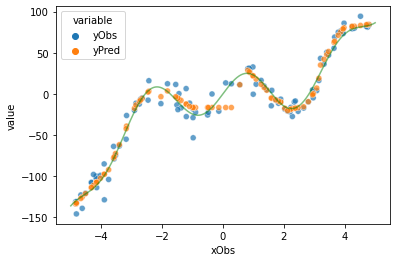

In [24]:
##################################################
## optimizer & training loop
##################################################

# initialize optimizer: Adam optimizer
loss_function = nn.MSELoss()
opt = torch.optim.Adam([U,V1,V2,W,b1,b2,b3], lr=1e-4)

epochs = 100000
for i in range(epochs+1):
    if (i == 0):
        print("\n")
    yPred = singleForwardPassBatched(xObs)
    loss  = loss_function(yPred, yObs)
    # loss  = torch.mean((yPred - yObs)**2)
    if (i == 0 or i % 5000 == 0):
        print('Iteration: {:5d} | Loss: {:12}'.format(i, loss.detach().numpy().round(0)))
        # print("Iteration: ", i, " Loss: ", loss.detach().numpy())
    loss.backward()
    opt.step()
    opt.zero_grad()

yPred = singleForwardPassBatched(xObs)

# plot the data
d = pd.DataFrame({'xObs' : xObs.detach().numpy(),
                  'yObs' : yObs.detach().numpy(),
                  'yPred': yPred.detach().numpy()})
dWide = pd.melt(d, id_vars = 'xObs', value_vars= ['yObs', 'yPred'])
sns.scatterplot(data = dWide, x = 'xObs', y = 'value', hue = 'variable', alpha = 0.7)
x = np.linspace(start = -5, stop =5, num = 1000)
y = goalFun(x)
plt.plot(x,y, color='g', alpha = 0.5)
plt.show()

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 4.1.3: Inspecting and interpreting the model fit</span></strong>
>
> 0. [just for yourself] Make sure that you understand all ingredients and steps used here. Read up on the MSE loss function, for instance, or ask if you are unsure.
>
> 1. Inspect the print-outs from the training sequence. Does this output suggest that the training was successful or not?
>
> 2. What does the plot produced here after training show exactly? Does that picture suggest that the model learned successfully? Do you think that there might even be a sense in which the model &ldquo;[overfitted](https://en.wikipedia.org/wiki/Overfitting)&rdquo; the data?
>
> 3. Change the optimizer to vanilla Gradient Descent (&rsquo;SGD&rsquo;), change the training rate to &rsquo;lr=1e-6&rsquo; and the number of training epochs to &rsquo;epochs = 50000&rsquo;.
> Now, (first re-initialize all parameter values to start training anew) and repeatedly execute the last code cell (probably 4-6 times).
> Describe what you observe by answering the following questions:
> (i) is training with &rsquo;SGD&rsquo; more or less efficient than the initial set-up?;
> (ii) why is it more/less efficient?
> (iii) if we think of training the model as &ldquo;curve fitting&rdquo;, which parts of the curve are adapted first, which ones later?
> (iv) explain the difference you described in (iii).



### Answer to Exercise 4.1.3.1
Based on the print-outs from the training sequence, the training should be successful, because the loss at the end was significantly less than in the begining, also, at least within the first 40000 iterations, the loss was going down a lot every time and the trend continued steadily, which means the model was able to learn and improve every time

### Answer to Exercise 4.1.3.2
This plot shows the true distribution of y over x (the blue line), the distribution of observed y over observed x (blue dots), and the distribution of predicted y over observed x.

In my opinion, although the plot shows that there were predictions that deviated from the true distribution (mainly the predictions on observed x around 0), in most of the area the predictions are still able to capture the true distribution, so I think the model in general learned successfully.

There are indeed overfitting at some spots. For instance, in the area where observed x is about -2, the y predictions deviated from the true distributions and went slightly down to meet the y observations, which were actually influenced by noises. The same also happed in the area where observed x is about 3.

### Answer to Exercise 4.1.3.3

In [ ]:
# re-initialize all parameter values to start training anew
U  = torch.tensor(np.random.rand(nHidden,nInput) * 2 - 1,
                  requires_grad=True)
V1 = torch.tensor(np.random.rand(nHidden, nHidden) * 2 - 1,
                  requires_grad=True)
V2 = torch.tensor(np.random.rand(nHidden, nHidden) * 2 - 1,
                  requires_grad=True)
W  = torch.tensor(np.random.rand(nOutput, nHidden) * 2 - 1,
                  requires_grad=True)
b1 = torch.zeros((nHidden,1), requires_grad=True)
b2 = torch.zeros((nHidden,1), requires_grad=True)
b3 = torch.zeros((nHidden,1), requires_grad=True)

def singleForwardPassBatched(xObs):
    xObsBatched = xObs.reshape(100,1,1)       # 100 1x1 matrices
    h1 = activationFun(U @ xObsBatched + b1)  # 100 column vectors
    h2 = activationFun(V1 @ h1 + b2)
    h3 = activationFun(V2 @ h2 + b3)
    y  = W @ h3
    yReshaped = torch.reshape(y,(-1,))
    return(yReshaped)



Iteration:     0 | Loss:        174.0
Iteration:  5000 | Loss:        134.0
Iteration: 10000 | Loss:        131.0
Iteration: 15000 | Loss:        129.0
Iteration: 20000 | Loss:        128.0
Iteration: 25000 | Loss:        127.0
Iteration: 30000 | Loss:        126.0
Iteration: 35000 | Loss:        125.0
Iteration: 40000 | Loss:        125.0
Iteration: 45000 | Loss:        121.0
Iteration: 50000 | Loss:        121.0


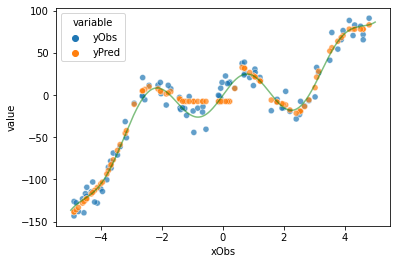

In [27]:
# initialize optimizer: Vanilla Gradient Descent
loss_function = nn.MSELoss()
opt = torch.optim.SGD([U,V1,V2,W,b1,b2,b3], lr=1e-6) # change the training rate to ’lr=1e-6’

epochs = 50000 # change the number of training epochs to ’epochs = 50000’
for i in range(epochs+1):
    if (i == 0):
        print("\n")
    yPred = singleForwardPassBatched(xObs)
    loss  = loss_function(yPred, yObs)
    # loss  = torch.mean((yPred - yObs)**2)
    if (i == 0 or i % 5000 == 0):
        print('Iteration: {:5d} | Loss: {:12}'.format(i, loss.detach().numpy().round(0)))
        # print("Iteration: ", i, " Loss: ", loss.detach().numpy())
    loss.backward()
    opt.step()
    opt.zero_grad()

yPred = singleForwardPassBatched(xObs)

# plot the data
d = pd.DataFrame({'xObs' : xObs.detach().numpy(),
                  'yObs' : yObs.detach().numpy(),
                  'yPred': yPred.detach().numpy()})
dWide = pd.melt(d, id_vars = 'xObs', value_vars= ['yObs', 'yPred'])
sns.scatterplot(data = dWide, x = 'xObs', y = 'value', hue = 'variable', alpha = 0.7)
x = np.linspace(start = -5, stop =5, num = 1000)
y = goalFun(x)
plt.plot(x,y, color='g', alpha = 0.5)
plt.show()



Iteration:     0 | Loss:        121.0
Iteration:  5000 | Loss:        120.0
Iteration: 10000 | Loss:        120.0
Iteration: 15000 | Loss:        120.0
Iteration: 20000 | Loss:        120.0
Iteration: 25000 | Loss:        119.0
Iteration: 30000 | Loss:        119.0
Iteration: 35000 | Loss:        119.0
Iteration: 40000 | Loss:        119.0
Iteration: 45000 | Loss:        119.0
Iteration: 50000 | Loss:        118.0


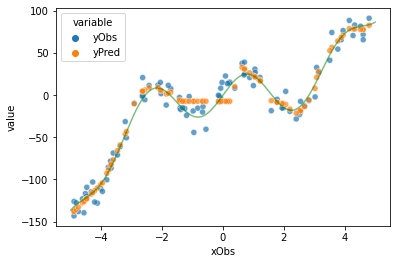

In [28]:
# repeatedly execute the last code cell (2nd time)

epochs = 50000 # change the number of training epochs to ’epochs = 50000’
for i in range(epochs+1):
    if (i == 0):
        print("\n")
    yPred = singleForwardPassBatched(xObs)
    loss  = loss_function(yPred, yObs)
    # loss  = torch.mean((yPred - yObs)**2)
    if (i == 0 or i % 5000 == 0):
        print('Iteration: {:5d} | Loss: {:12}'.format(i, loss.detach().numpy().round(0)))
        # print("Iteration: ", i, " Loss: ", loss.detach().numpy())
    loss.backward()
    opt.step()
    opt.zero_grad()

yPred = singleForwardPassBatched(xObs)

# plot the data
d = pd.DataFrame({'xObs' : xObs.detach().numpy(),
                  'yObs' : yObs.detach().numpy(),
                  'yPred': yPred.detach().numpy()})
dWide = pd.melt(d, id_vars = 'xObs', value_vars= ['yObs', 'yPred'])
sns.scatterplot(data = dWide, x = 'xObs', y = 'value', hue = 'variable', alpha = 0.7)
x = np.linspace(start = -5, stop =5, num = 1000)
y = goalFun(x)
plt.plot(x,y, color='g', alpha = 0.5)
plt.show()